In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import theano.tensor as tt
import scipy

from packages.analysis.analyze import *

In [3]:
# use subprocess to scp a file cedar.computecanada.ca to the local machine. The file is named "all_languages_results_2023-01-28_compositional.csv". 
# The file is located in the directory "/home/fsamir8/scratch/augmentation_subset_select" on cedar.computecanada.ca. 
# Copy the file to the current directory on the local machine.
# subprocess.run(["scp", "fsamir8@cedar.computecanada.ca:/home/fsamir8/scratch/augmentation_subset_select/all_languages_results_2023-01-28_compositional.csv", "."])
# scp 4 more files that have seed=0,1,2,3 after results_ and before the date 2023-02-01
for i in range(4):
    subprocess.run(["scp", f"fsamir8@cedar.computecanada.ca:/home/fsamir8/scratch/augmentation_subset_select/all_languages_results_seed={i}_2023-02-01_compositional.csv", "."])


In [3]:
results_frame_first = load_results_frame_compositional("all_languages_results_2023-01-17_compositional.csv") 
# load the results frame from the file "all_languages_results_2023-01-28_compositional.csv" and store it in the variable results_frame_first
# then concatenate that with the results frame from the file "all_languages_results_2023-01-28_compositional.csv" and store it in the variable results_frame

results_frame_second = load_results_frame_compositional("all_languages_results_2023-01-28_compositional.csv")
# load the 2023-02-01 results frames and concatenate it with the above 2
for i in range(4):
    results_frame_second = pd.concat([results_frame_second, load_results_frame_compositional(f"all_languages_results_seed={i}_2023-02-01_compositional.csv")])
results_frame = pd.concat([results_frame_first, results_frame_second])
results_frame = add_kwargs_to_frame(results_frame)
results_frame = results_frame[results_frame['data_quantity'] == 'low']
# print the head of the results frame, followed by the number of rows
print(results_frame.head())
print(len(results_frame))


                                                 method  result  \
1.0   uncertainty_sample_num_aug=2048_r=1.0_train_me...   0.163   
6.0   uat_num_aug=512_train_medium=False_use_empiric...   0.237   
7.0   uncertainty_sample_num_aug=256_r=1.0_train_med...   0.212   
9.0   uncertainty_sample_num_aug=512_r=1.0_train_med...   0.238   
13.0              random_num_aug=256_train_medium=False   0.146   

     num_eval_datapoints language  num_aug  \
1.0                 1000  bengali     2048   
6.0                 1000  bengali      512   
7.0                 1000  bengali      256   
9.0                 1000  bengali      512   
13.0                1000  bengali      256   

                               method_class data_quantity  valid  
1.0         uncertainty_use_high_loss=False           low   True  
6.0   uat_use_empirical=False_use_loss=True           low   True  
7.0          uncertainty_use_high_loss=True           low   True  
9.0          uncertainty_use_high_loss=True         

In [3]:
from sklearn import preprocessing
def preprocess_results_frame(frame, language_le, method_class_le):
    frame = frame.copy()
    # assert there are no infinities or negative infinities in result
    # frame.replace([np.inf, -np.inf], np.nan, inplace=True)
    # replace result with a small positive value if it is 0
    frame['result'] = frame['result'].apply(lambda x: 1e-3 if x == 0 else x)
    frame['result_logit'] = frame['result'].apply(scipy.special.logit)
    frame['log_num_aug'] = frame['num_aug'].apply(lambda x: np.log2(x/64) if x != 0 else 0)
    # check if there are nan values in method_class_i, result_logit, log_num_aug, language_i
    frame['language_i'] = language_le.transform(frame['language'])
    frame['method_class_i'] = method_class_le.transform(frame['method_class'])
    print(frame[['method_class_i', 'result_logit', 'log_num_aug', 'language_i']].isnull().values.any())

    return frame
language_le = preprocessing.LabelEncoder()
language_le.fit(results_frame['language'])
method_class_le = preprocessing.LabelEncoder()
method_class_le.fit(results_frame['method_class'])
preproc_frame = preprocess_results_frame(results_frame, language_le, method_class_le)
# print the length of preproc_frame and results_frame
print(len(preproc_frame))
print(len(results_frame))


False
1474
1474


In [4]:
model = pm.Model()
with model:
    # create pm.Data called method_class, containing method_class_i from preproc_frame
    method_class = pm.Data('method_class', preproc_frame['method_class_i'])
    language = pm.Data('language', preproc_frame['language_i'])
    log_num_aug = pm.Data('log_num_aug', preproc_frame['log_num_aug'])

    sigma_parameter = pm.HalfNormal('model_err', sigma=1) 
    
    bias_parameter = pm.Normal('bias', 0, sigma=1, shape=(1,))
    mu_method_class_parameter = pm.Normal('mu_method_class', 0, sigma=1, shape=(len(preproc_frame['method_class_i'].unique()),))
    mu_language_parameter = pm.Normal('mu_language', 0, sigma=1, shape=(len(preproc_frame['language_i'].unique()),))
    mu_log_num_aug_parameter = pm.Normal('mu_log_num_aug', 0, sigma=1, shape=(1,))

    # expected value
    logit_acc_est = bias_parameter + mu_method_class_parameter[method_class] + mu_language_parameter[language] + mu_log_num_aug_parameter * log_num_aug 
    logit_acc_likelihood = pm.Normal('y_like', logit_acc_est, sigma= sigma_parameter, observed=preproc_frame['result_logit']) # TODO: add the logit transformed.

    trace = pm.sample(2000, tune=1000, cores=2, chains=2)
        


/tmp/ipykernel_912/572955635.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=1000, cores=2, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log_num_aug, mu_language, mu_method_class, bias, model_err]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 200 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [55]:
# create another model which has a global mu_method_class parameter (same as above) as well as a language-specific mu_method_class parameter. The shape for the latter should be (len(preproc_frame['language_i'].unique()), len(preproc_frame['method_class_i'].unique())).
    # the language-specific mu_method_class parameter should be initialized to the global mu_method_class parameter.
    # the language-specific mu_method_class parameter should then be added to the expected value of the logit_acc_est instead of the global mu_method_class parameter.

model_hierarchical = pm.Model()
with model_hierarchical:
    # create pm.Data called method_class, containing method_class_i from preproc_frame
    method_class = pm.Data('method_class', preproc_frame['method_class_i'])
    language = pm.Data('language', preproc_frame['language_i'])
    log_num_aug = pm.Data('log_num_aug', preproc_frame['log_num_aug'])

    err_parameter = pm.HalfNormal('model_err', sigma=1) 
    
    bias_parameter = pm.Normal('bias', 0, sigma=1, shape=(1,))
    mu_language_parameter = pm.Normal('mu_language', 0, sigma=1, shape=(len(preproc_frame['language_i'].unique()),))
    mu_log_num_aug_parameter = pm.Normal('mu_log_num_aug', 0, sigma=1, shape=(1,))
    mu_global_method_class_parameter = pm.Normal('mu_method_class', 0, sigma=1, shape=(len(preproc_frame['method_class_i'].unique()),)) # hyperprior
    mu_lang_specific_method_class_parameter = pm.Normal('mu_lang_specific_method_class', mu_global_method_class_parameter, sigma=1, shape=(len(preproc_frame['language_i'].unique()), len(preproc_frame['method_class_i'].unique())))

    # print the shape of the mu_lang_specific_method_class_parameter.
    print(f"Shape of lang specific method class: {mu_lang_specific_method_class_parameter.shape}")
    logit_acc_est = bias_parameter + mu_lang_specific_method_class_parameter[(language, method_class)] + mu_language_parameter[language] + mu_log_num_aug_parameter * log_num_aug 
    logit_acc_likelihood = pm.Normal('y_like', logit_acc_est, sigma=err_parameter, observed=preproc_frame['result_logit']) # TODO: add the logit transformed.

    trace_hierarchical = pm.sample(2000, tune=1000, cores=2, chains=2)



Shape of lang specific method class: Shape.0


/tmp/ipykernel_912/309410611.py:25: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_hierarchical = pm.sample(2000, tune=1000, cores=2, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_lang_specific_method_class, mu_method_class, mu_log_num_aug, mu_language, bias, model_err]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 358 seconds.
The number of effective samples is smaller than 25% for some parameters.


/tmp/ipykernel_22370/2401652802.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


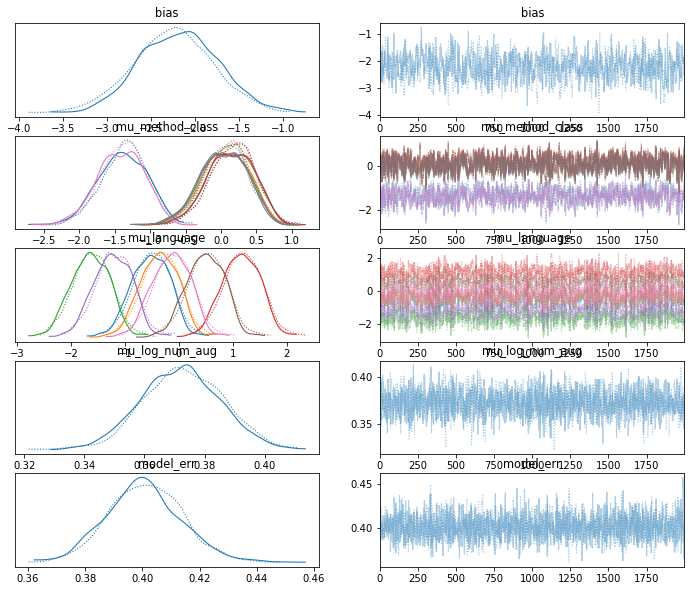

In [29]:
# plot the trace
with model:
    pm.traceplot(trace)


In [202]:
preproc_frame.head()

,method,result,num_eval_datapoints,language,num_aug,method_class,data_quantity,valid,result_logit,log_num_aug,language_i,method_class_i
1.0,uncertainty_sample_num_aug=2048_r=1.0_train_me...,0.163,1000,bengali,2048,uncertainty_use_high_loss=False,low,True,-1.636074,5.0,1,5
6.0,uat_num_aug=512_train_medium=False_use_empiric...,0.237,1000,bengali,512,uat_use_empirical=False_use_loss=True,low,True,-1.169198,3.0,1,3
7.0,uncertainty_sample_num_aug=256_r=1.0_train_med...,0.212,1000,bengali,256,uncertainty_use_high_loss=True,low,True,-1.312912,2.0,1,6
9.0,uncertainty_sample_num_aug=512_r=1.0_train_med...,0.238,1000,bengali,512,uncertainty_use_high_loss=True,low,True,-1.163676,3.0,1,6
13.0,random_num_aug=256_train_medium=False,0.146,1000,bengali,256,random,low,True,-1.766325,2.0,1,1


In [6]:
import itertools
# write a function that takes a language and model. it then loops over all combinations of method_class and log_num_aug and returns a dataframe with the posterior predictive distribution for each combination.
def get_posterior_predictive(language, model):
    method_classes = method_class_le.classes_
    log_num_aug = [128, 256, 512, 1024, 2048]
    # get all combinations of method_class and log_num_aug
    combinations = list(itertools.product(method_classes, log_num_aug))
    # create a dataframe with the combinations with columns "method_class" and "log_num_aug"
    df = pd.DataFrame(combinations, columns=['method_class', 'num_aug'])
    # add the language column
    df['language'] = language
    # add a column with the result. this is not used in the simulation
    df['result'] = 0.5
    # preprocess the dataframe
    preproc_df_test = preprocess_results_frame(df, language_le, method_class_le)
    # set the data in the model
    pm.set_data({'method_class': preproc_df_test['method_class_i'], 'language': preproc_df_test['language_i'], 'log_num_aug': preproc_df_test['log_num_aug']})
    # sample from the posterior predictive distribution
    y_pred = pm.sample_posterior_predictive(trace, samples=4000, random_seed=42)
    # print the shape of the y_pred['y_like'] array with a format string
    print(f"y_pred['y_like'].shape: {y_pred['y_like'].shape}")
    # create a dataframe with the posterior predictive distribution. each combination of method_class and log_num_aug will appear 4000 times, once for each sample
    df = pd.DataFrame({'method_class': np.repeat(df['method_class'], 4000), 'log_num_aug': np.repeat(df['num_aug'], 4000), 'y_pred': y_pred['y_like'].flatten('F')})
    # apply the inverse logit transformation and save the result in a new column called accuracy
    df['accuracy'] = 1 / (1 + np.exp(-df['y_pred']))
    # return the dataframe
    return df
with model:
    # get the posterior predictive distribution for the arabic language
    posterior_predictive = get_posterior_predictive('bengali', model)


    

    

False


y_pred['y_like'].shape: (4000, 40)


In [43]:
# repeat the bar plot above for every language.
from packages.utils.constants import LANGUAGES
posterior_predictive_frames = [] 
hue_order = results_frame['method_class'].unique()
with model:
    for i in range(language_le.classes_.shape[0]):
        language = language_le.classes_[i]
        posterior_predictive = get_posterior_predictive(language, model)
        posterior_predictive_frames.append(posterior_predictive)

False


y_pred['y_like'].shape: (4000, 40)
False


y_pred['y_like'].shape: (4000, 40)
False


y_pred['y_like'].shape: (4000, 40)
False


y_pred['y_like'].shape: (4000, 40)
False


y_pred['y_like'].shape: (4000, 40)
False


y_pred['y_like'].shape: (4000, 40)
False


y_pred['y_like'].shape: (4000, 40)


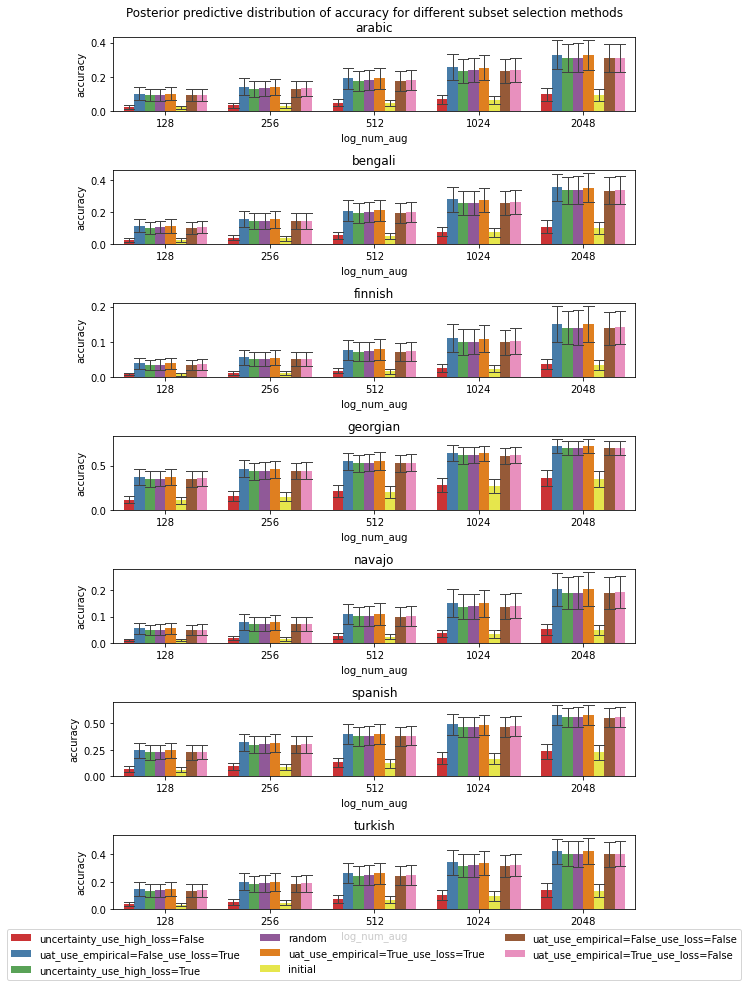

In [52]:
# loop over the languages and plot the posterior predictive distribution for each language using the regular model
from packages.utils.constants import LANGUAGES
fig, axes =  plt.subplots(len(LANGUAGES), 1, figsize= (10,14))
with model:
    for i in range(language_le.classes_.shape[0]):
        language = language_le.classes_[i]
        ax = axes[i]
        posterior_predictive = posterior_predictive_frames[i]
        # plot the posterior predictive distribution for each method_class, grouped by log_num_aug
        sns.barplot(x='log_num_aug', y='accuracy', data=posterior_predictive,  capsize=0.1, errwidth=1, errorbar=('sd'), ax = ax, hue='method_class', palette='Set1', hue_order=hue_order)
        ax.set_title(language)
# remove legend for all but the last plot
for i in range(len(LANGUAGES)-1):
    axes[i].get_legend().remove()
# place the legend in the last plot at the bottom
axes[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
# add a title for the whole figure: Posterior predictive distribution of accuracy for different subset selection methods
fig.suptitle('Posterior predictive distribution of accuracy for different subset selection methods')
plt.tight_layout()
plt.show()

In [56]:
# do the same for the hierarchical model
posterior_predictive_frames_hierarchical = []
with model_hierarchical:
    for i in range(language_le.classes_.shape[0]):
        language = language_le.classes_[i]
        posterior_predictive = get_posterior_predictive(language, model_hierarchical)
        posterior_predictive_frames_hierarchical.append(posterior_predictive)

# loop over the languages and plot the posterior predictive distribution for each language using the hierarchical model

False


y_pred['y_like'].shape: (4000, 40)
False


y_pred['y_like'].shape: (4000, 40)
False


y_pred['y_like'].shape: (4000, 40)
False


y_pred['y_like'].shape: (4000, 40)
False


y_pred['y_like'].shape: (4000, 40)
False


y_pred['y_like'].shape: (4000, 40)
False


y_pred['y_like'].shape: (4000, 40)


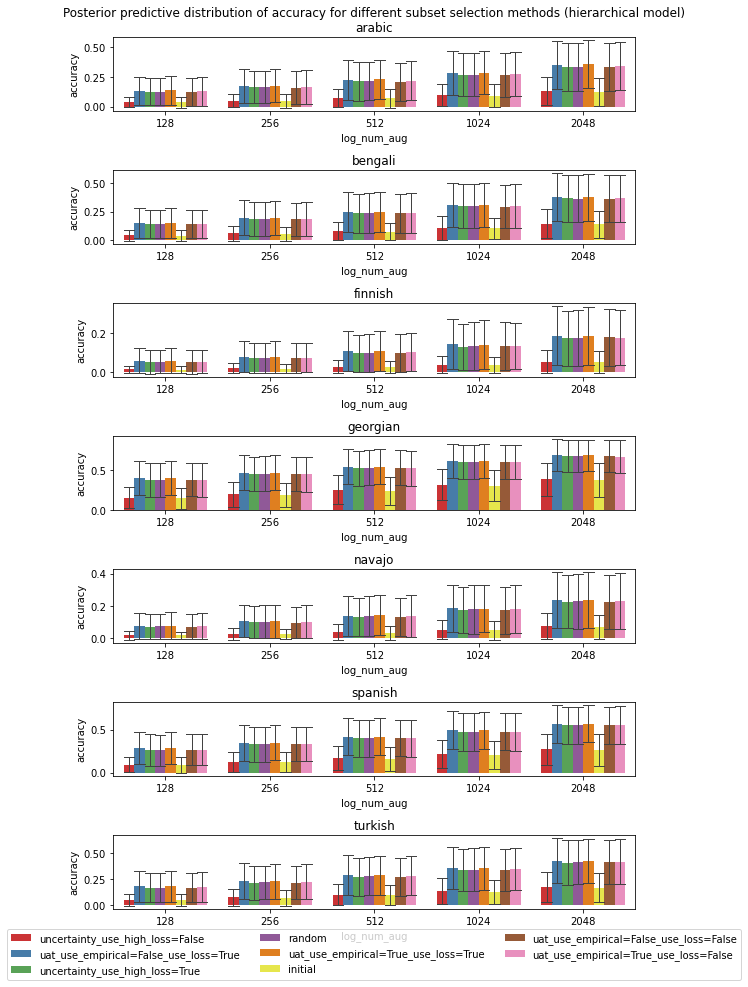

In [57]:
# loop over the languages and plot the posterior predictive distribution for each language using the hierarchical model
from packages.utils.constants import LANGUAGES
fig, axes =  plt.subplots(len(LANGUAGES), 1, figsize= (10,14))
with model_hierarchical:
    for i in range(language_le.classes_.shape[0]):
        language = language_le.classes_[i]
        ax = axes[i]
        posterior_predictive = posterior_predictive_frames_hierarchical[i]
        # plot the posterior predictive distribution for each method_class, grouped by log_num_aug
        sns.barplot(x='log_num_aug', y='accuracy', data=posterior_predictive,  capsize=0.1, errwidth=1, errorbar=('sd'), ax = ax, hue='method_class', palette='Set1', hue_order=hue_order)
        ax.set_title(language)
for i in range(len(LANGUAGES)-1):
    axes[i].get_legend().remove()
# place the legend in the last plot at the bottom
axes[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
# add a title for the whole figure: Posterior predictive distribution of accuracy for different subset selection methods
fig.suptitle('Posterior predictive distribution of accuracy for different subset selection methods (hierarchical model)')
plt.tight_layout()
plt.show()


NameError: name 'language_le' is not defined

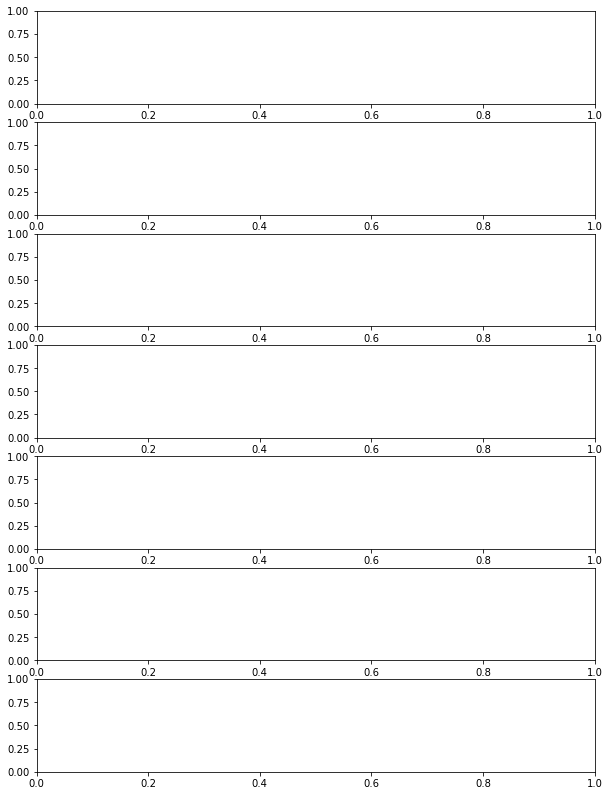

In [4]:
# Plot the raw results from the results dataframe. This is the same as the plot above, but without the posterior predictive distribution.
# create fig with subplots for each language
fig, axes =  plt.subplots(len(LANGUAGES), 1, figsize= (10,14))
for i in range(language_le.classes_.shape[0]):
    ax = axes[i]
    language = language_le.classes_[i]
    sns.barplot(x='num_aug', y='result', data=results_frame[results_frame['language'] == language], capsize=0.1, errwidth=1, errorbar=('sd', 1), ax=ax, hue='method_class', palette='Set1', hue_order=hue_order)
    ax.set_title(language)

for i in range(len(LANGUAGES)-1):
    axes[i].get_legend().remove()
# place the legend in the last plot at the bottom
axes[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
# add a title for the whole figure: Posterior predictive distribution of accuracy for different subset selection methods
fig.suptitle('Accuracy of different models')
plt.tight_layout()
plt.show()


In [13]:
# print the average accuracy for the "uat_use_empirical=False_use_loss=True" model for each language when using 128 num_aug
from packages.utils.constants import LANGUAGES

# print('Average accuracy for the "uat_use_empirical=False_use_loss=True" model for each language when using 128 num_aug')
# for language in LANGUAGES:
#     print(language, results_frame[(results_frame['method_class'] == 'uat_use_empirical=False_use_loss=True') & (results_frame['num_aug'] == 128) & (results_frame['language'] == language)]['result'].mean())
#     print(language, results_frame[(results_frame['method_class'] == 'random') & (results_frame['num_aug'] == 128) & (results_frame['language'] == language)]['result'].mean())

# print('Average accuracy for the "uat_use_empirical=False_use_loss=True" model for each language when using 256 num_aug')
# for language in LANGUAGES:
#     print(language, results_frame[(results_frame['method_class'] == 'uat_use_empirical=False_use_loss=True') & (results_frame['num_aug'] == 256) & (results_frame['language'] == language)]['result'].mean())
#     print(language, results_frame[(results_frame['method_class'] == 'random') & (results_frame['num_aug'] == 256) & (results_frame['language'] == language)]['result'].mean())

# Group the results_frame by language and num_aug, then count how many times each method_class has the highest accuracy.
# This is the same as the table in the paper.
# print('Group the results_frame by language and num_aug, then count how many times each method_class has the highest accuracy.')

# For each language and num_aug, get the method_class that has the highest accuracy from the results_frame. 

# print('For each language and num_aug, get the method_class that has the highest accuracy from the results_frame.')


# average the accuracy over the method class for each language and num_aug
results_frame_grouped = results_frame.groupby(['language', 'num_aug', 'method_class']).mean().reset_index()
# print the size of the results_frame_grouped compared to the results_frame
print('results_frame_grouped size:', results_frame_grouped.shape)
print('results_frame size:', results_frame.shape)

# get the method_class with the highest accuracy for each language and num_aug
results_frame_grouped_max = results_frame_grouped.groupby(['language', 'num_aug']).apply(lambda x: x[x['result'] == x['result'].max()]).reset_index(drop=True)
# drop rows with the initial method_class
results_frame_grouped_max = results_frame_grouped_max[results_frame_grouped_max['method_class'] != 'initial']
print(results_frame_grouped_max)
# print the normalized value counts of the method class from results_frame_grouped_max
print(results_frame_grouped_max['method_class'].value_counts(normalize=True))
# print the normalized value counts of the method class from results_frame_grouped_max without the uat_use_empirical=True_use_loss=True
print(results_frame_grouped_max[results_frame_grouped_max['method_class'] != 'uat_use_empirical=True_use_loss=True']['method_class'].value_counts(normalize=True))

# Use results_frame_grouped to get the difference in the average accuracy of method_class="uat_use_empirical=False_use_loss=True" and method_class="random" for each language and num_aug.
# Then, average the difference over the languages and num_aug.

# print('Use results_frame_grouped to get the difference in the average accuracy of method_class="uat_use_empirical=False_use_loss=True" and method_class="random" for each language and num_aug.')
# print('Then, average the difference over the languages and num_aug.')







results_frame_grouped size: (252, 5)
results_frame size: (1474, 8)
    language  num_aug                           method_class    result  valid
1     arabic      128   uat_use_empirical=True_use_loss=True  0.070167    1.0
2     arabic      256   uat_use_empirical=True_use_loss=True  0.159167    1.0
3     arabic      512   uat_use_empirical=True_use_loss=True  0.281500    1.0
4     arabic     1024   uat_use_empirical=True_use_loss=True  0.338667    1.0
5     arabic     2048   uat_use_empirical=True_use_loss=True  0.333833    1.0
7    bengali      128  uat_use_empirical=False_use_loss=True  0.119000    1.0
8    bengali      256  uat_use_empirical=False_use_loss=True  0.180333    1.0
9    bengali      512   uat_use_empirical=True_use_loss=True  0.263500    1.0
10   bengali     1024  uat_use_empirical=False_use_loss=True  0.298000    1.0
11   bengali     2048                                 random  0.297833    1.0
13   finnish      128         uncertainty_use_high_loss=True  0.042000    1

In [40]:
# Then, average the difference over the languages and num_aug.
# print('use the results_frame to get the difference in the average accuracy of method_class="uat_use_empirical=False_use_loss=True" and method_class="random" for each language and num_aug.')
# print('Then, average the difference over the languages and num_aug.')
results_frame_grouped = results_frame.groupby(['language', 'num_aug', 'method_class']).mean().reset_index()
# drop rows with the initial method_class
results_frame_grouped = results_frame_grouped[results_frame_grouped['method_class'] != 'initial']
# use the results_frame_grouped to get the difference in the average accuracy of method_class="uat_use_empirical=False_use_loss=True" and method_class="random" for each language and num_aug.
print(results_frame_grouped.head())

diff_frame = (results_frame_grouped).groupby(['language', 'num_aug']).apply(lambda x: x[x['method_class'] == 'uat_use_empirical=False_use_loss=True']['result'].values[0] - x[x['method_class'] == 'random']['result'].values[0])

# group by language and print the average
print(diff_frame.groupby('language').mean())
# group by num_aug and print the average
print(diff_frame.groupby('num_aug').mean())

# use the three statements above, but perform the groupby on results_frame_grouped without num_aug=2048 rows

# use the same two print statements as above, bt after dropping the num_aug=2048 rows
# print(diff_frame[diff_frame['num_aug'] != 2048].groupby('language').mean())
# print(diff_frame[diff_frame['num_aug'] != 2048].groupby('num_aug').mean())

  language  num_aug                            method_class    result  valid
1   arabic      128                                  random  0.056167    1.0
2   arabic      128  uat_use_empirical=False_use_loss=False  0.052500    1.0
3   arabic      128   uat_use_empirical=False_use_loss=True  0.061333    1.0
4   arabic      128   uat_use_empirical=True_use_loss=False  0.053000    1.0
5   arabic      128    uat_use_empirical=True_use_loss=True  0.070167    1.0
language
arabic      0.004767
bengali     0.025733
finnish    -0.009000
georgian    0.048433
navajo      0.011333
spanish     0.013100
turkish    -0.019033
dtype: float64
num_aug
128     0.021619
256     0.022976
512     0.016024
1024    0.003262
2048   -0.010071
dtype: float64


In [ ]:
# use the normalized value counts of the method_class from results_frame_grouped_max to show a pie chart

